In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 5.5
fig_height = 3.5
fig_format = :pdf
fig_dpi = 300

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/vituri/Documentos/GitHub/blog/posts/symbolic regression"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


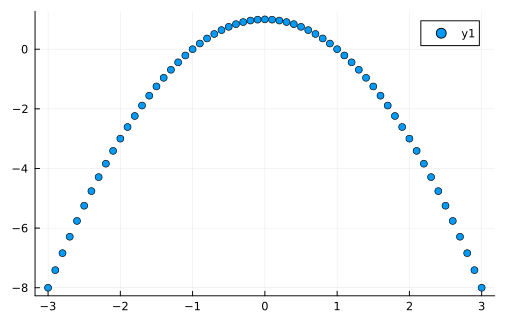

In [2]:
using SymbolicRegression, MLJ, SymbolicUtils
using Plots

x = [-3:0.1:3;]
y = @. - x^2 + 1;

scatter(x, y)

In [3]:
model = SRRegressor(
    binary_operators=[+, -, *],    
    niterations=50
);

In [4]:
#| output: false
X = reshape(x, (length(x), 1))

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/750 [00:00<-1:-40, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.037e+01  3.604e+01  y = -0.45971                                  7           5.895e+00  9.418e-02  y = (((x₁ * x₁) * -0.25649) * 1.0109)         9           1.928e-01  1.710e+00  y = (((-0.71633 - x₁) + -0.41624) * (x₁ + -1.2359))                                                                           11          5.018e-21  1.802e+01  y = ((((-0.89184 - x₁) + -0.50346) - -0.3953) * (x₁ + -1))                            

1.6%┣▊                                            ┫ 12/750 [00:00<00:19, 38it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.704e+00  3.604e+01  y = -1.9518                                   3           7.694e+00  6.354e-04  y = (-1.9518 - 0.2586)                        5           0.000e+00  1.802e+01  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
2.7%┣█▏                                           ┫ 20/750 [00:00<00:13, 55it/s]Expressions evaluate

3.6%┣█▋                                           ┫ 27/750 [00:00<00:11, 64it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.5%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
4.5%┣██                                           ┫ 34/750 [00:00<00:10, 71it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <

5.5%┣██▌                                          ┫ 41/750 [00:01<00:09, 77it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


6.0%┣██▊                                          ┫ 45/750 [00:01<00:10, 74it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
6.7%┣███                                          ┫ 50/750 [00:01<00:09, 74it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.0%         Press 'q' and then <

7.3%┣███▎                                         ┫ 55/750 [00:01<00:09, 75it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
8.0%┣███▋                                         ┫ 

60/750 [00:01<00:09, 75it/s]Expressions evaluated per second: [.....]. Head worker occupation: 2.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
8.8%┣████                                         ┫ 66/750 [00:01<00:09, 76it/s]Expressions evaluated per second: [.....]. Head worker occupation: 2.9%         Press 'q' and then <enter> to stop execution early.                     

9.6%┣████▎                                        ┫ 72/750 [00:01<00:09, 77it/s]Expressions evaluated per second: [.....]. Head worker occupation: 2.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


10.4%┣████▋                                       ┫ 78/750 [00:01<00:09, 78it/s]Expressions evaluated per second: [.....]. Head worker occupation: 2.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
11.1%┣████▉                                       ┫ 83/750 [00:01<00:09, 77it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 2.9%        Press 'q' and then <

12.0%┣█████▎                                      ┫ 90/750 [00:01<00:08, 79it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 2.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
12.9%┣█████▊                                      ┫ 97/750 [00:01<00:08, 81it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 2.9%        Press 'q' and then <

13.9%┣██████                                     ┫ 104/750 [00:01<00:08, 83it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


15.1%┣██████▌                                    ┫ 113/750 [00:01<00:07, 85it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
16.1%┣███████                                    ┫ 121/750 [00:01<00:07, 87it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <

17.2%┣███████▍                                   ┫ 129/750 [00:01<00:07, 89it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
18.1%┣███████▉                                   ┫ 136/750 [00:01<00:07, 90it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <

19.1%┣████████▏                                  ┫ 143/750 [00:02<00:07, 91it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


20.0%┣████████▋                                  ┫ 150/750 [00:02<00:07, 92it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
20.9%┣█████████                                  ┫ 157/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <

21.9%┣█████████▍                                 ┫ 164/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
22.7%┣█████████▊                                 ┫ 170/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <

23.5%┣██████████                                 ┫ 176/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


24.3%┣██████████▍                                ┫ 182/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
24.9%┣██████████▊                                ┫ 187/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 9.28e+04. Head worker occupation: 3.1%        Press 'q' and then <

25.7%┣███████████                                ┫ 193/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


26.5%┣███████████▍                               ┫ 199/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
27.2%┣███████████▊                               ┫ 204/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <

27.9%┣████████████                               ┫ 209/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


28.7%┣████████████▎                              ┫ 215/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
29.5%┣████████████▊                              ┫ 221/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <

30.3%┣█████████████                              ┫ 227/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
31.3%┣█████████████▌                             ┫ 235/750 [00:03<00:06, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <

32.1%┣█████████████▉                             ┫ 241/750 [00:03<00:06, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


32.9%┣██████████████▏                            ┫ 247/750 [00:03<00:05, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
33.7%┣██████████████▌                            ┫ 253/750 [00:03<00:05, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <

34.5%┣██████████████▉                            ┫ 259/750 [00:03<00:05, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
35.3%┣███████████████▏                           ┫ 265/750 [00:03<00:05, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <

36.1%┣███████████████▌                           ┫ 271/750 [00:03<00:05, 92it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


37.2%┣████████████████                           ┫ 279/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.13e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
37.9%┣████████████████▎                          ┫ 284/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

38.8%┣████████████████▊                          ┫ 291/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
39.6%┣█████████████████                          ┫ 297/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

40.3%┣█████████████████▎                         ┫ 302/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
41.2%┣█████████████████▊                         ┫ 309/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

42.1%┣██████████████████▏                        ┫ 316/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


42.9%┣██████████████████▌                        ┫ 322/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
43.9%┣██████████████████▉                        ┫ 329/750 [00:03<00:04, 94it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

44.7%┣███████████████████▏                       ┫ 335/750 [00:04<00:04, 94it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
45.6%┣███████████████████▋                       ┫ 342/750 [00:04<00:04, 94it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

46.4%┣████████████████████                       ┫ 348/750 [00:04<00:04, 94it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


47.3%┣████████████████████▍                      ┫ 355/750 [00:04<00:04, 95it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
48.3%┣████████████████████▊                      ┫ 362/750 [00:04<00:04, 95it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

49.6%┣█████████████████████▎                     ┫ 372/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
50.4%┣█████████████████████▊                     ┫ 378/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.0%        Press 'q' and then <

51.5%┣██████████████████████▏                    ┫ 386/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.07e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


52.1%┣██████████████████████▍                    ┫ 391/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
52.9%┣██████████████████████▊                    ┫ 397/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

53.7%┣███████████████████████                    ┫ 403/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
54.5%┣███████████████████████▌                   ┫ 409/750 [00:04<00:04, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

55.3%┣███████████████████████▉                   ┫ 415/750 [00:04<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


56.1%┣████████████████████████▏                  ┫ 421/750 [00:04<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
56.9%┣████████████████████████▌                  ┫ 427/750 [00:04<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

57.6%┣████████████████████████▊                  ┫ 432/750 [00:04<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
58.3%┣█████████████████████████                  ┫ 437/750 [00:05<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

58.9%┣█████████████████████████▍                 ┫ 442/750 [00:05<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


59.9%┣█████████████████████████▊                 ┫ 449/750 [00:05<00:03, 96it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
60.5%┣██████████████████████████                 ┫ 454/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

61.2%┣██████████████████████████▎                ┫ 459/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
62.0%┣██████████████████████████▋                ┫ 465/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

62.8%┣███████████████████████████                ┫ 471/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
63.6%┣███████████████████████████▍               ┫ 477/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.12e+05. Head worker occupation: 3.0%        Press 'q' and then <

64.4%┣███████████████████████████▊               ┫ 483/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


65.3%┣████████████████████████████               ┫ 490/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
66.1%┣████████████████████████████▍              ┫ 496/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <

67.1%┣████████████████████████████▉              ┫ 503/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


68.0%┣█████████████████████████████▎             ┫ 510/750 [00:05<00:03, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
68.8%┣█████████████████████████████▋             ┫ 516/750 [00:05<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <

69.5%┣█████████████████████████████▉             ┫ 521/750 [00:05<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
70.1%┣██████████████████████████████▏            ┫ 526/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <

70.9%┣██████████████████████████████▌            ┫ 532/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


71.9%┣███████████████████████████████            ┫ 539/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
72.7%┣███████████████████████████████▎           ┫ 545/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <

73.3%┣███████████████████████████████▌           ┫ 550/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
74.3%┣████████████████████████████████           ┫ 557/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <

75.1%┣████████████████████████████████▎          ┫ 563/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


75.7%┣████████████████████████████████▋          ┫ 568/750 [00:06<00:02, 95it/s]Expressions evaluated per second: 1.10e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


76.3%┣████████████████████████████████▉          ┫ 572/750 [00:06<00:02, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
77.1%┣█████████████████████████████████▏         ┫ 578/750 [00:06<00:02, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <

78.0%┣█████████████████████████████████▌         ┫ 585/750 [00:06<00:02, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


78.9%┣██████████████████████████████████         ┫ 592/750 [00:06<00:02, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
79.7%┣██████████████████████████████████▎        ┫ 598/750 [00:06<00:02, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <

80.5%┣██████████████████████████████████▋        ┫ 604/750 [00:06<00:02, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
81.2%┣███████████████████████████████████        ┫ 609/750 [00:06<00:01, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <

81.9%┣███████████████████████████████████▏       ┫ 614/750 [00:07<00:01, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


82.7%┣███████████████████████████████████▌       ┫ 620/750 [00:07<00:01, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
83.5%┣████████████████████████████████████       ┫ 626/750 [00:07<00:01, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <

84.1%┣████████████████████████████████████▏      ┫ 631/750 [00:07<00:01, 94it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


84.9%┣████████████████████████████████████▌      ┫ 637/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
85.7%┣████████████████████████████████████▉      ┫ 643/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <

86.5%┣█████████████████████████████████████▏     ┫ 649/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


87.3%┣█████████████████████████████████████▌     ┫ 655/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.08e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
88.1%┣██████████████████████████████████████     ┫ 661/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <

88.8%┣██████████████████████████████████████▏    ┫ 666/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
89.5%┣██████████████████████████████████████▌    ┫ 671/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <

90.1%┣██████████████████████████████████████▊    ┫ 676/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


90.8%┣███████████████████████████████████████    ┫ 681/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
91.6%┣███████████████████████████████████████▍   ┫ 687/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <

92.5%┣███████████████████████████████████████▉   ┫ 694/750 [00:07<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


93.2%┣████████████████████████████████████████   ┫ 699/750 [00:08<00:01, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
93.9%┣████████████████████████████████████████▍  ┫ 704/750 [00:08<00:00, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <

94.8%┣████████████████████████████████████████▊  ┫ 711/750 [00:08<00:00, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


95.5%┣█████████████████████████████████████████  ┫ 716/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
96.4%┣█████████████████████████████████████████▌ ┫ 723/750 [00:08<00:00, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <

97.3%┣█████████████████████████████████████████▉ ┫ 730/750 [00:08<00:00, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


98.1%┣██████████████████████████████████████████▏┫ 736/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
99.1%┣██████████████████████████████████████████▋┫ 743/750 [00:08<00:00, 93it/s]Expressions evaluated per second: 1.05e+05. Head worker occupation: 3.0%        Press 'q' and then <

99.6%┣██████████████████████████████████████████▉┫ 747/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @315 ⏎ AbstractMatrix{Continuous}
    2:	Source @265 ⏎ AbstractVector{Continuous}


In [5]:
r = report(mach);

r

(best_idx = 2,
 equations = DynamicExpressions.EquationModule.Node{Float64}[-2.100000000025821, (1.0 - (x₁ * x₁))],
 equation_strings = ["-2.100000000025821", "(1.0 - (x₁ * x₁))"],
 losses = [7.681799999999998, 0.0],
 complexities = [1, 5],
 scores = [36.04365338911715, 9.010913347279288],)

In [6]:
r.losses

2-element Vector{Float64}:
 7.681799999999998
 0.0

In [7]:
r.equations

2-element Vector{DynamicExpressions.EquationModule.Node{Float64}}:
 -2.100000000025821
 (1.0 - (x₁ * x₁))

In [8]:
node_to_symbolic(r.equations[r.best_idx], model)

1.0 - (x1 * x1)

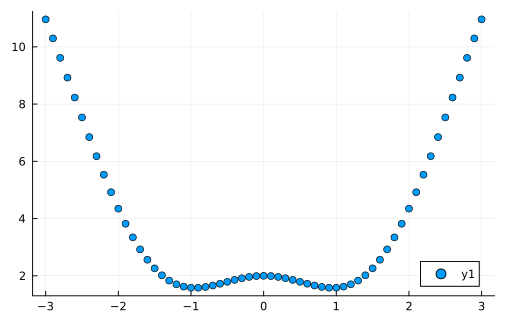

In [9]:
y = @. x^2 + 2cos(x)^2 

scatter(x, y)

In [10]:
#| output: false

model = SRRegressor(
    binary_operators = [+, -, *],    
    unary_operators = [cos],
    niterations=50
);

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/750 [00:00<00:-10, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.935e+01  3.604e+01  y = 0.82373                                   2           1.823e+01  5.915e-02  y = cos(-0.027248)                            3           1.425e+00  2.549e+00  y = (x₁ * x₁)                                 5           6.655e-01  3.808e-01  y = (0.5444 + (x₁ * x₁))                      6           4.843e-01  3.178e-01  y = (cos(0.23083) + (x₁ * x₁))                8           4.114e-01  8.166e-02  y = (c

1.6%┣▊                                            ┫ 12/750 [00:00<00:10, 71it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.759e+01  3.604e+01  y = 1.1059                                    3           1.425e+00  1.257e+00  y = (x₁ * x₁)                                 5           4.844e-01  5.396e-01  y = (0.96159 + (x₁ * x₁))                     6           4.843e-01  1.254e-04  y = (cos(0.23083) + (x₁ * x₁))                7           4.805e-01  7.925e-03  y = (0.78161 + ((x₁ * 1.0308) * x₁))          8           4.114e-01  1.554e-01  y = (c

2.5%┣█▏                                           ┫ 19/750 [00:00<00:09, 84it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.759e+01  3.604e+01  y = 1.1059                                    3           1.425e+00  1.257e+00  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.333e-01  2.105e-01  y = ((

4.7%┣██                                          ┫ 35/750 [00:00<00:07, 102it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.338e+01  3.604e+01  y = 1.9306                                    3           1.425e+00  1.120e+00  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = (c

6.7%┣███                                         ┫ 50/750 [00:00<00:06, 109it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.3%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.338e+01  3.604e+01  y = 1.9306                                    3           1.425e+00  1.120e+00  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = (c

8.8%┣███▉                                        ┫ 66/750 [00:01<00:06, 114it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.338e+01  3.604e+01  y = 1.9306                                    3           1.425e+00  1.120e+00  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = (c

10.0%┣████▎                                      ┫ 75/750 [00:01<00:06, 114it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = (c

12.1%┣█████▏                                     ┫ 91/750 [00:01<00:06, 116it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

13.5%┣█████▋                                    ┫ 101/750 [00:01<00:05, 119it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

15.5%┣██████▌                                   ┫ 116/750 [00:01<00:05, 120it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

17.3%┣███████▎                                  ┫ 130/750 [00:01<00:05, 120it/s]Expressions evaluated per second: 2.03e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

19.3%┣████████▏                                 ┫ 145/750 [00:01<00:05, 120it/s]Expressions evaluated per second: 2.03e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

20.3%┣████████▌                                 ┫ 152/750 [00:01<00:05, 120it/s]Expressions evaluated per second: 2.03e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

21.3%┣█████████▏                                 ┫ 160/750 [00:02<00:06, 95it/s]Expressions evaluated per second: 2.03e+05. Head worker occupation: 3.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

22.0%┣█████████▌                                 ┫ 165/750 [00:02<00:07, 83it/s]Expressions evaluated per second: 2.03e+05. Head worker occupation: 2.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

24.0%┣██████████▎                                ┫ 180/750 [00:02<00:07, 86it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 2.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.559e-01  6.102e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3269)          10          1.109e-23  1.802e+01  y = ((

26.4%┣███████████▍                               ┫ 198/750 [00:02<00:06, 89it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

27.6%┣███████████▉                               ┫ 207/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

29.7%┣████████████▉                              ┫ 223/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

32.1%┣█████████████▉                             ┫ 241/750 [00:03<00:05, 95it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

33.2%┣██████████████▎                            ┫ 249/750 [00:03<00:05, 96it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

35.7%┣███████████████▍                           ┫ 268/750 [00:03<00:05, 98it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

38.1%┣████████████████                          ┫ 286/750 [00:03<00:05, 100it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

39.3%┣████████████████▌                         ┫ 295/750 [00:03<00:04, 101it/s]Expressions evaluated per second: 1.39e+05. Head worker occupation: 3.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

41.3%┣█████████████████▍                        ┫ 310/750 [00:03<00:04, 102it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

43.5%┣██████████████████▎                       ┫ 326/750 [00:03<00:04, 103it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

44.7%┣██████████████████▊                       ┫ 335/750 [00:03<00:04, 104it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

46.8%┣███████████████████▋                      ┫ 351/750 [00:03<00:04, 105it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

48.9%┣████████████████████▌                     ┫ 367/750 [00:03<00:04, 106it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

49.9%┣█████████████████████                     ┫ 374/750 [00:04<00:04, 106it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

52.0%┣█████████████████████▉                    ┫ 390/750 [00:04<00:03, 107it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

53.9%┣██████████████████████▋                   ┫ 404/750 [00:04<00:03, 107it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

55.9%┣███████████████████████▌                  ┫ 419/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

56.9%┣████████████████████████                  ┫ 427/750 [00:04<00:03, 108it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

59.2%┣████████████████████████▉                 ┫ 444/750 [00:04<00:03, 109it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

61.6%┣█████████████████████████▉                ┫ 462/750 [00:04<00:03, 110it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

63.5%┣██████████████████████████▋               ┫ 476/750 [00:04<00:02, 110it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

64.4%┣███████████████████████████               ┫ 483/750 [00:04<00:02, 110it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

66.4%┣███████████████████████████▉              ┫ 498/750 [00:04<00:02, 111it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

67.6%┣████████████████████████████▍             ┫ 507/750 [00:05<00:02, 111it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

69.5%┣█████████████████████████████▏            ┫ 521/750 [00:05<00:02, 111it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

71.5%┣██████████████████████████████            ┫ 536/750 [00:05<00:02, 111it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

72.3%┣██████████████████████████████▍           ┫ 542/750 [00:05<00:02, 111it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

74.7%┣███████████████████████████████▍          ┫ 560/750 [00:05<00:02, 112it/s]Expressions evaluated per second: 1.81e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

76.9%┣████████████████████████████████▎         ┫ 577/750 [00:05<00:02, 113it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

78.1%┣████████████████████████████████▉         ┫ 586/750 [00:05<00:01, 113it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

80.1%┣█████████████████████████████████▋        ┫ 601/750 [00:05<00:01, 113it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

82.3%┣██████████████████████████████████▌       ┫ 617/750 [00:05<00:01, 113it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

83.3%┣███████████████████████████████████       ┫ 625/750 [00:05<00:01, 114it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

85.5%┣████████████████████████████████████      ┫ 641/750 [00:06<00:01, 114it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

87.5%┣████████████████████████████████████▊     ┫ 656/750 [00:06<00:01, 114it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

88.7%┣█████████████████████████████████████▎    ┫ 665/750 [00:06<00:01, 115it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

90.7%┣██████████████████████████████████████    ┫ 680/750 [00:06<00:01, 115it/s]Expressions evaluated per second: 1.87e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

92.8%┣███████████████████████████████████████   ┫ 696/750 [00:06<00:00, 115it/s]Expressions evaluated per second: 1.90e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

93.7%┣███████████████████████████████████████▍  ┫ 703/750 [00:06<00:00, 115it/s]Expressions evaluated per second: 1.90e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

95.7%┣████████████████████████████████████████▏ ┫ 718/750 [00:06<00:00, 115it/s]Expressions evaluated per second: 1.90e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

96.8%┣████████████████████████████████████████▋ ┫ 726/750 [00:06<00:00, 115it/s]Expressions evaluated per second: 1.90e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

98.7%┣█████████████████████████████████████████▍┫ 740/750 [00:06<00:00, 115it/s]Expressions evaluated per second: 1.90e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = ((cos(x₁) + (x₁ * x₁)) * 1.3284)          10          1.109e-23  1.802e+01  y = ((

trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @555 ⏎ AbstractMatrix{Continuous}
    2:	Source @438 ⏎ AbstractVector{Continuous}


In [11]:
r = report(mach)
node_to_symbolic(r.equations[r.best_idx], model)

((x1 * x1) + (cos(x1 + x1) * 1.000000000000011)) - -1.0000000000000162

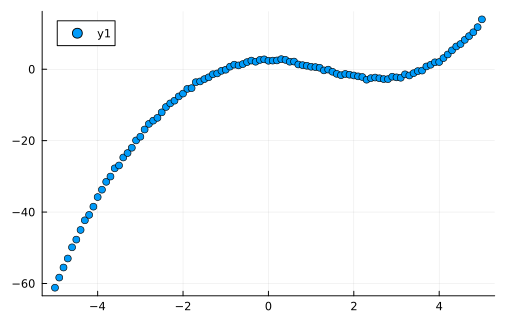

In [12]:
x = [-5:0.1:5;]
X = reshape(x, (length(x), 1))
errors = rand(length(x))
y = @. 0.3*x^3 - x^2 + 2cos(x) + errors

scatter(x, y)

In [13]:
#| output: false
model = SRRegressor(
    binary_operators = [+, -, *],    
    unary_operators = [cos],
    niterations=60
);

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                              ┫ 0/900 [00:00<00:-2, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.813e+02  3.604e+01  y = x₁                                        5           2.223e+02  5.883e-02  y = (x₁ - (0.39382 - x₁))                     7           2.136e+02  2.003e-02  y = (x₁ - ((1.4769 - x₁) + -0.51576))         8           1.917e+02  1.084e-01  y = (x₁ - ((cos(1.4769) - x₁) - x₁))          9           1.781e+02  7.364e-02  y = (x₁ - ((1.4769 - (x₁ + x₁)) + -0.51576))  11          4.164e+01  7.265e-01  y = (x

2.0%┣▉                                           ┫ 18/900 [00:00<00:07, 132it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.1%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.813e+02  3.604e+01  y = x₁                                        3           2.144e+02  1.357e-01  y = (x₁ * 2.3489)                             5           1.451e+02  1.953e-01  y = (x₁ - (x₁ * x₁))                          7           3.604e+01  6.964e-01  y = (x₁ - (x₁ * (x₁ - 3.3363)))               9           3.557e+01  6.617e-03  y = (0.22494 - (x₁ * ((x₁ + -1.1547) - 3.3363)))                                      

3.4%┣█▌                                          ┫ 31/900 [00:00<00:07, 120it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.813e+02  3.604e+01  y = x₁                                        3           2.144e+02  1.357e-01  y = (x₁ * 2.3489)                             5           3.549e+01  8.994e-01  y = (x₁ * (4.5912 - x₁))                      7           3.547e+01  2.307e-04  y = ((x₁ + 0.027702) * (4.6189 - x₁))         8           2.879e+01  2.088e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          12          2.855e+01  2.091e-03  y = (x

4.1%┣█▉                                          ┫ 37/900 [00:00<00:08, 110it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.813e+02  3.604e+01  y = x₁                                        3           1.765e+02  2.331e-01  y = (x₁ * 3.8389)                             5           3.549e+01  8.021e-01  y = (x₁ * (4.5912 - x₁))                      7           3.547e+01  2.307e-04  y = (0.12795 - (x₁ * (x₁ - 4.5912)))          8           2.879e+01  2.088e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          2.832e+01  8.157e-03  y = ((

5.6%┣██▌                                         ┫ 50/900 [00:00<00:08, 108it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.547e+01  2.307e-04  y = (0.12795 - (x₁ * (x₁ - 4.5912)))          8           2.879e+01  2.088e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          2.336e+01  1.043e-01  y = (x

6.4%┣██▉                                         ┫ 58/900 [00:01<00:08, 111it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.547e+01  2.307e-04  y = (0.12795 - (x₁ * (x₁ - 4.5912)))          8           2.879e+01  2.088e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          2.336e+01  1.043e-01  y = (x

8.1%┣███▋                                        ┫ 73/900 [00:01<00:07, 112it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.547e+01  2.307e-04  y = (0.12795 - (x₁ * (x₁ - 4.5912)))          8           2.879e+01  2.088e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

9.6%┣████▏                                       ┫ 86/900 [00:01<00:07, 110it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.547e+01  2.307e-04  y = (0.12795 - (x₁ * (x₁ - 4.5912)))          8           2.879e+01  2.088e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

10.2%┣████▍                                      ┫ 92/900 [00:01<00:07, 108it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

11.6%┣████▉                                     ┫ 104/900 [00:01<00:08, 105it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

12.2%┣█████▏                                    ┫ 110/900 [00:01<00:08, 104it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

13.6%┣█████▊                                    ┫ 122/900 [00:01<00:08, 102it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

14.2%┣██████                                    ┫ 128/900 [00:01<00:08, 102it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

15.6%┣██████▌                                   ┫ 140/900 [00:01<00:08, 101it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

17.0%┣███████▏                                  ┫ 153/900 [00:02<00:07, 100it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

17.8%┣███████▌                                  ┫ 160/900 [00:02<00:07, 101it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

19.4%┣████████▏                                 ┫ 175/900 [00:02<00:07, 102it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

20.1%┣████████▌                                 ┫ 181/900 [00:02<00:07, 102it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

21.6%┣█████████                                 ┫ 194/900 [00:02<00:07, 101it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

22.3%┣█████████▍                                ┫ 201/900 [00:02<00:07, 101it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

23.6%┣██████████▏                                ┫ 212/900 [00:02<00:07, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

24.8%┣██████████▋                                ┫ 223/900 [00:02<00:07, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

25.3%┣███████████                                ┫ 228/900 [00:02<00:07, 98it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

26.7%┣███████████▌                               ┫ 240/900 [00:02<00:07, 98it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          10          1.773e+01  2.422e-01  y = (x

28.0%┣████████████                               ┫ 252/900 [00:03<00:07, 97it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

28.8%┣████████████▍                              ┫ 259/900 [00:03<00:07, 97it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

30.3%┣█████████████                              ┫ 273/900 [00:03<00:06, 98it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

31.0%┣█████████████▎                             ┫ 279/900 [00:03<00:06, 96it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

32.8%┣██████████████                             ┫ 295/900 [00:03<00:07, 90it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

33.4%┣██████████████▍                            ┫ 301/900 [00:03<00:07, 90it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

34.8%┣███████████████                            ┫ 313/900 [00:03<00:07, 90it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

36.3%┣███████████████▋                           ┫ 327/900 [00:04<00:06, 90it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

37.1%┣████████████████                           ┫ 334/900 [00:04<00:06, 91it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

38.9%┣████████████████▊                          ┫ 350/900 [00:04<00:06, 92it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

40.3%┣█████████████████▍                         ┫ 363/900 [00:04<00:06, 92it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

41.2%┣█████████████████▊                         ┫ 371/900 [00:04<00:06, 93it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

42.6%┣██████████████████▎                        ┫ 383/900 [00:04<00:06, 93it/s]Expressions evaluated per second: 1.57e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

43.3%┣██████████████████▋                        ┫ 390/900 [00:04<00:05, 93it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

45.0%┣███████████████████▍                       ┫ 405/900 [00:04<00:05, 93it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

45.8%┣███████████████████▊                       ┫ 412/900 [00:04<00:05, 93it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

47.2%┣████████████████████▎                      ┫ 425/900 [00:05<00:05, 94it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

48.8%┣█████████████████████                      ┫ 439/900 [00:05<00:05, 94it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

49.7%┣█████████████████████▍                     ┫ 447/900 [00:05<00:05, 94it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

51.2%┣██████████████████████                     ┫ 461/900 [00:05<00:05, 95it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

52.7%┣██████████████████████▋                    ┫ 474/900 [00:05<00:04, 95it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

53.3%┣███████████████████████                    ┫ 480/900 [00:05<00:04, 95it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.7%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

54.8%┣███████████████████████▌                   ┫ 493/900 [00:05<00:04, 95it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

56.3%┣████████████████████████▎                  ┫ 507/900 [00:05<00:04, 96it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

57.1%┣████████████████████████▋                  ┫ 514/900 [00:05<00:04, 96it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

58.6%┣█████████████████████████▏                 ┫ 527/900 [00:05<00:04, 96it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

60.0%┣█████████████████████████▉                 ┫ 540/900 [00:06<00:04, 96it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

60.9%┣██████████████████████████▏                ┫ 548/900 [00:06<00:04, 97it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

62.4%┣██████████████████████████▉                ┫ 562/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

63.9%┣███████████████████████████▌               ┫ 575/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

64.6%┣███████████████████████████▊               ┫ 581/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

66.1%┣████████████████████████████▍              ┫ 595/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.69e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

67.8%┣█████████████████████████████▏             ┫ 610/900 [00:06<00:03, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

68.6%┣█████████████████████████████▌             ┫ 617/900 [00:06<00:03, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

70.0%┣██████████████████████████████             ┫ 630/900 [00:06<00:03, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

71.6%┣██████████████████████████████▊            ┫ 644/900 [00:07<00:03, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

72.3%┣███████████████████████████████            ┫ 651/900 [00:07<00:03, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

74.1%┣███████████████████████████████▉           ┫ 667/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

75.0%┣████████████████████████████████▎          ┫ 675/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

76.6%┣█████████████████████████████████          ┫ 689/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

78.2%┣█████████████████████████████████▋         ┫ 704/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

79.0%┣██████████████████████████████████         ┫ 711/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

80.6%┣██████████████████████████████████▋        ┫ 725/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

81.2%┣███████████████████████████████████        ┫ 731/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

82.6%┣███████████████████████████████████▌       ┫ 743/900 [00:07<00:02, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

83.9%┣████████████████████████████████████       ┫ 755/900 [00:08<00:01, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

84.7%┣████████████████████████████████████▍      ┫ 762/900 [00:08<00:01, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

86.1%┣█████████████████████████████████████      ┫ 775/900 [00:08<00:01, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((x₁ * (x₁ - 3.414)) * (x₁ * 0.29987))    11          1.426e+00  7.923e-02  y = ((

88.4%┣██████████████████████████████████████     ┫ 796/900 [00:08<00:01, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

89.9%┣██████████████████████████████████████▋    ┫ 809/900 [00:08<00:01, 99it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

90.6%┣██████████████████████████████████████    ┫ 815/900 [00:08<00:01, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

92.0%┣██████████████████████████████████████▋   ┫ 828/900 [00:08<00:01, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

92.9%┣███████████████████████████████████████   ┫ 836/900 [00:08<00:01, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

94.3%┣███████████████████████████████████████▋  ┫ 849/900 [00:09<00:01, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

95.8%┣████████████████████████████████████████▎ ┫ 862/900 [00:09<00:00, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

96.6%┣████████████████████████████████████████▌ ┫ 869/900 [00:09<00:00, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

98.0%┣█████████████████████████████████████████▏┫ 882/900 [00:09<00:00, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

98.8%┣█████████████████████████████████████████▌┫ 889/900 [00:09<00:00, 100it/s]Expressions evaluated per second: 1.75e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.808e+02  3.604e+01  y = -8.372                                    3           1.717e+02  2.459e-01  y = (x₁ * 4.5912)                             5           3.549e+01  7.883e-01  y = (x₁ * (4.5912 - x₁))                      7           3.541e+01  1.035e-03  y = (x₁ * ((4.4847 - x₁) * 1.0238))           8           2.879e+01  2.072e-01  y = (x₁ * ((cos(x₁) + 5.0302) - x₁))          9           1.671e+00  2.846e+00  y = ((

trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @462 ⏎ AbstractMatrix{Continuous}
    2:	Source @376 ⏎ AbstractVector{Continuous}


In [14]:
r = report(mach)
node_to_symbolic(r.equations[r.best_idx], model)

((x1 * x1) * ((x1 * 0.29986748329119267) - 0.9999233101548928)) - ((cos(x1) * -1.9516984547914216) - 0.4921120734630974)

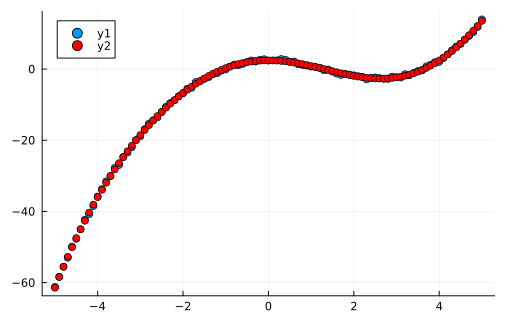

In [15]:
y_pred = predict(mach, X)
 
scatter(x, y);
scatter!(x, y_pred, color = "red")